# <u>Multivariate Outlier Detection in Geochemical Datasets</u>

This notebook is intended as an open-source resource for exploring, analyzing and comparing three different methods of outlier detection in geochemical datasets in the context of mineral exploration.  
<br />
<br />
The three primary outlier detection algorithms we will use are the following: 
- Isolation Forests (IF) (Liu et al., 2008)
- Local Outlier Factor (LOF) (Breunig et al., 2000)
- Angle Based Outlier Detection (ABOD) (Shahrestani & Sanislav, 2025)
<br />
<br />

This work is driven from the findings in Antoine Caté's article on multivariate outlier detection for mineral exploration.

<br />
<br />
<u>References: </u>

*Breunig, M. M., Kriegel, H.-P., Ng, R. T., and Sander, J., 2000, LOF: Identifying Density-Based Local Outliers: ACM SIGMOD Record, v. 29, no. 2, p. 93-104.*

*Liu, F. T., Ting, K. M., and Zhou, Z.-H., 2008, Isolation Forest, 2008 Eighth IEEE International Conference on Data Mining, p. 413-422.*

*Maklin, C., 2022, Isolation Forest - Cory Maklin - Medium: Medium, https://medium.com/@corymaklin/isolation-forest-799fceacdda4.*

*Shahrestani, S., and Sanislav, I., 2025, Mapping geochemical anomalies using angle-based outlier detection approach: Journal of Geochemical Exploration, v. 269.*
<br />

---

In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from typing import Tuple
import matplotlib.pyplot as plt

*For the testing of these algorithms we are going to use geochemical data from a region in southwestern Saudi Arabia. All units are converted to ppm for consistency.*

In [27]:
# Import and preview the data, create a copy of the data with only numeric columns
data_filepath = "/Users/thowe/MinersAI Dropbox/Tyler Howe/KSA Data/KSA_GSAS_data.csv"
df = pd.read_csv(data_filepath)
print(df.head(3))

  Sample Field Number  Longitude   Latitude       Br      Cl     Cr       Hf  \
0         421911AD001  42.772083  19.993880  1.41950  62.743  47.29  3.49742   
1         421911AD002  42.778492  19.996819  2.13468  28.329  52.81  4.82120   
2         421911AD003  42.814612  19.982057  1.89862  31.059  35.74  5.69027   

         P      Rb        Ti  ...      Sb      Se        Ag         B  \
0  759.625  41.156  3307.385  ...  0.4220  0.2038  0.036737  16.64191   
1  828.342  45.921  4517.659  ...  0.8238  0.1229  0.045773  12.55748   
2  769.358  50.198  5789.542  ...  1.2301  0.1830  0.050043  12.21876   

         Sn      F       N      S      TC      LOI  
0  1.402524  487.1   89.39  124.6  6725.0  38100.0  
1  1.902777  442.5   86.80   62.2  4647.0  35300.0  
2  2.071384  521.3  127.60   66.3  6186.0  39100.0  

[3 rows x 60 columns]


### <u>Isolation Forests</u>

Isolation forests are an unsupervised machine learning method of outlier/anomaly detection. It is an ensemble method that combines the predictions of several decision trees to assign an anomaly score to a given data point. Samples that require fewer splits across all trees are given a lower anomaly score (higher likelihood of being anomalous). This method of outlier detection is not affected by data distribution, but does require some parameter-tuning. 

In [28]:
def isolation_forest(
    data: pd.DataFrame,
    feature_columns: list = None,
    contamination: float = 0.05,
    random_state: int = 42,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Detect outliers in a geochemical dataset using the Isolation Forest algorithm.

    Parameters:
    - data (pd.DataFrame): The input geochemical dataset.
    - feature_columns (list): List of column names to be used as features.
                              If None, all numerical columns will be used.
    - contamination (float): The proportion of outliers in the dataset (default: 0.05).
    - random_state (int): Random seed for reproducibility (default: 42).

    Returns:
    - Tuple[pd.DataFrame, pd.DataFrame]:
        1. DataFrame with additional columns:
            - 'outlier': Binary classification (-1 = outlier, 1 = inlier).
            - 'anomaly_score': Continuous anomaly score (lower = more anomalous).
        2. DataFrame containing only the detected outliers.
    """
    # Make a copy of the input DataFrame to avoid modifying the original
    data_copy = data.copy()

    # Validate inputs
    if not isinstance(data_copy, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame.")

    # Use all numerical columns if feature_columns is None
    if feature_columns is None:
        feature_columns = data_copy.select_dtypes(include=[np.number]).columns.tolist()
        if not feature_columns:
            raise ValueError(
                "No numerical columns found in the dataset to use as features."
            )

    if not all(col in data_copy.columns for col in feature_columns):
        raise ValueError("Some feature columns are not present in the dataset.")
    if not 0 < contamination < 0.5:
        raise ValueError("Contamination must be between 0 and 0.5.")

    # Prepare the data
    features = data_copy[feature_columns].copy()

    # Handle missing values by imputing with column mean
    if features.isnull().values.any():
        features = features.fillna(features.mean())

    # Initialize and fit the Isolation Forest model
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
    iso_forest.fit(features)

    # Add the binary classification to the copied DataFrame
    data_copy["outlier"] = iso_forest.predict(features)

    # Add the continuous anomaly scores to the copied DataFrame
    data_copy["anomaly_score"] = iso_forest.decision_function(features)

    # Separate outliers based on binary classification
    outliers = data_copy[data_copy["outlier"] == -1]

    return data_copy, outliers

In [33]:
# Run the function

feature_columns = ['Br', 'Cl', 'Cr', 'Hf',
       'P', 'Rb', 'Ti', 'Zr', 'SiO2', 'Al2O3', 'TFe2O3', 'K2O', 'Ba', 'Mn',
       'Sr', 'V', 'Zn', 'MgO', 'CaO', 'Na2O', 'Be', 'Bi', 'Co', 'Cs', 'Cu',
       'Ga', 'In', 'Li', 'Mo', 'Nb', 'Ni', 'Tl', 'Te', 'Sc', 'Y', 'Ge', 'I',
       'Ta', 'W', 'Re', 'Au', 'Ir', 'Os', 'Pd', 'Pt', 'Rh', 'Ru', 'Sb', 'Se',
       'Ag', 'B', 'Sn', 'F', 'N', 'S', 'TC', 'LOI']

IF_df, outliers = isolation_forest(
    df, feature_columns, contamination=0.1
)

print("Processed Data:")
print(IF_df)
print("\nOutliers:")
print(outliers)

Processed Data:
     Sample Field Number  Longitude   Latitude       Br       Cl     Cr  \
0            421911AD001  42.772083  19.993880  1.41950   62.743  47.29   
1            421911AD002  42.778492  19.996819  2.13468   28.329  52.81   
2            421911AD003  42.814612  19.982057  1.89862   31.059  35.74   
3            421911AD004  42.837565  19.998416  1.24168   32.693  32.15   
4            421911AD005  42.857754  20.000042  0.74926   27.891  52.77   
...                  ...        ...        ...      ...      ...    ...   
2723         421934CA113  42.193506  19.273612  1.18994  107.140  17.70   
2724         421934CA114  42.215084  19.272444  1.60039  132.180  13.45   
2725         421934CA115  42.238421  19.274462  1.30542  116.054  22.32   
2726         421934CA116  42.208574  19.440659  1.20503  170.320  37.13   
2727         421934CA117  42.034688  19.437610  2.60739  122.658  39.56   

            Hf        P      Rb        Ti  ...        Ag          B        Sn  \
0 

In [47]:
def plot_outlier_results(
    data: pd.DataFrame,
    x_col: str,
    y_col: str,
    score_col: str,
    binary_col: str,
    point_size: float = 100,
    score_title: str = "Anomaly Score",
    binary_title: str = "Binary Classification",
    plot_title: str = "Outlier Detection Results",
    cmap: str = "coolwarm",
    binary_colors: dict = None,
):
    """
    Plot the results of outlier detection with a score-based heatmap and binary classification.

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing geospatial and outlier information.
    - x_col (str): Column name for x-axis (e.g., 'Longitude').
    - y_col (str): Column name for y-axis (e.g., 'Latitude').
    - score_col (str): Column name for continuous anomaly scores.
    - binary_col (str): Column name for binary classification (-1 for outliers, 1 for inliers).
    - point_size (float): Size of the points in the scatter plots (default: 100).
    - score_title (str): Title for the score-based plot (default: "Anomaly Score").
    - binary_title (str): Title for the binary plot (default: "Binary Classification").
    - plot_title (str): Title for the entire figure (default: "Outlier Detection Results").
    - cmap (str): Colormap for the score plot (default: "coolwarm").
    - binary_colors (dict): Optional custom color map for binary classification
                            (default: {1: "blue", -1: "red"}).
    """
    # Default binary colors if not provided
    if binary_colors is None:
        binary_colors = {1: "blue", -1: "red"}

    # Check if required columns exist in the data
    for col in [x_col, y_col, score_col, binary_col]:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in the data.")

    # Create the figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

    # Plot the score-based heatmap
    sc1 = axes[0].scatter(
        data[x_col],
        data[y_col],
        c=data[score_col],
        cmap=cmap,
        s=point_size,  # Use point_size here
    )
    cbar1 = fig.colorbar(sc1, ax=axes[0])
    cbar1.set_label(score_title, fontsize=12)
    axes[0].set_title(score_title, fontsize=14)
    axes[0].set_xlabel(x_col, fontsize=12)
    axes[0].set_ylabel(y_col, fontsize=12)
    axes[0].grid(True)

    # Plot the binary classification
    axes[1].scatter(
        data[x_col],
        data[y_col],
        c=data[binary_col].map(binary_colors),
        s=point_size,  # Use point_size here
        label="Inliers/Outliers",
    )
    axes[1].set_title(binary_title, fontsize=14)
    axes[1].set_xlabel(x_col, fontsize=12)
    axes[1].set_ylabel(y_col, fontsize=12)
    axes[1].grid(True)

    # Add a legend for binary classification
    legend_labels = {
        1: "Inlier",
        -1: "Outlier",
    }
    handles = [
        plt.Line2D(
            [0], [0], marker="o", color="w", markerfacecolor=color, markersize=10
        )
        for value, color in binary_colors.items()
    ]
    labels = [legend_labels.get(value, str(value)) for value in binary_colors.keys()]
    axes[1].legend(handles, labels, loc="upper right", fontsize=12)

    # Set the overall plot title
    plt.suptitle(plot_title, fontsize=18)
    plt.show()

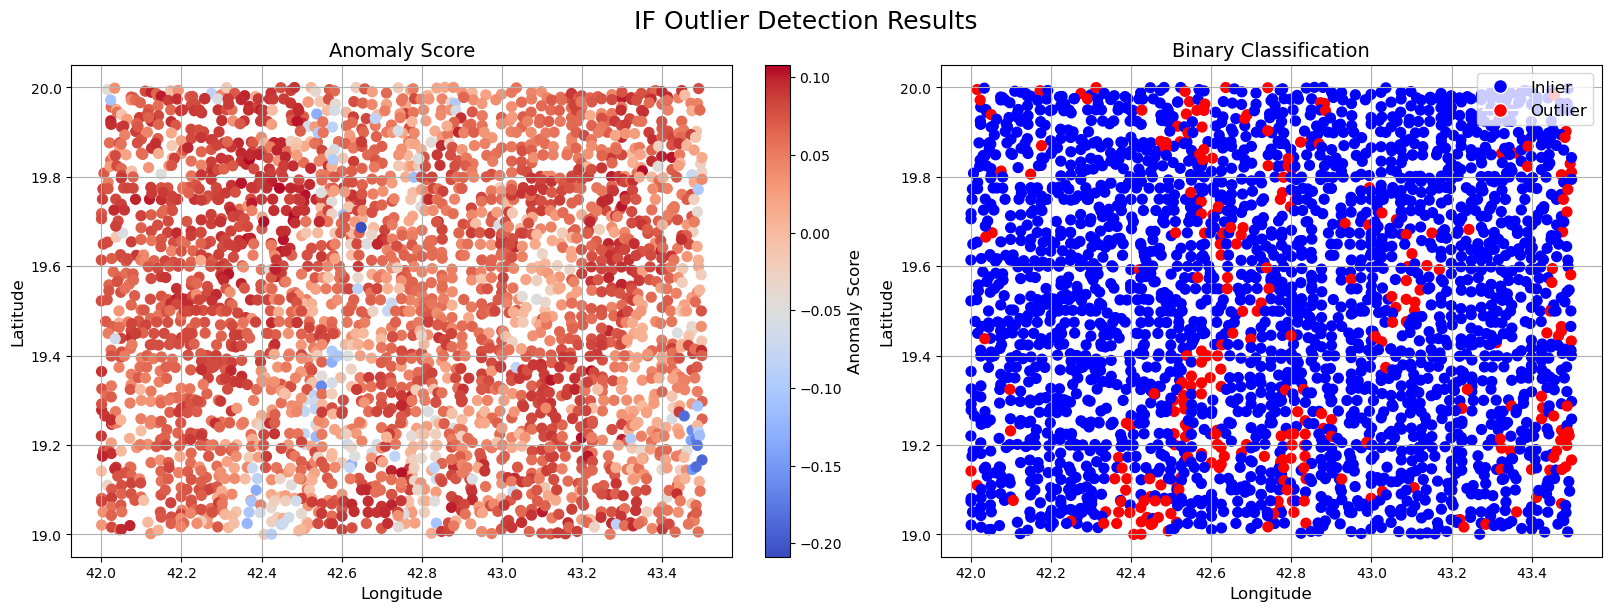

In [49]:
# Plotting results
plot_outlier_results(
    data=IF_df,
    x_col="Longitude",
    y_col="Latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="IF Outlier Detection Results",
)